In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [4]:
# この関数は以下のURLから引用
# http://mzsm.me/2010/10/26/%E7%A2%BA%E7%8E%87%E3%82%92%E6%8C%87%E5%AE%9A%E3%81%97%E3%81%A6%E3%83%AA%E3%82%B9%E3%83%88%E3%81%8B%E3%82%89%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%81%AB%E5%8F%96%E5%BE%97%E3%81%99%E3%82%8B/
import random
def choose(candidates, probabilities):
    probabilities = [sum(probabilities[:x+1]) for x in range(len(probabilities))]
    if probabilities[-1] > 1.0:
        #確率の合計が100%を超えていた場合は100％になるように調整する
        probabilities = [x/probabilities[-1] for x in probabilities]
    rand = random.random()
    for candidate, probability in zip(candidates, probabilities):
        if rand < probability:
            return candidate
    #どれにも当てはまらなかった場合はNoneを返す
    return None

In [5]:
class MCL():
    def __init__(self, pclg):    # パーティクルの数を調整するゲインを引数にとる
        # 位置xの範囲を指定
        self.x = np.arange(0, 11, 1)
        
        # ドアの位置を指定
        self.door = [2, 4, 9]
        
        # 観測の成功率と失敗率を指定（状態はドアの有無の二つとする）
        self.o_suc = 0.8
        self.o_fail = 0.2
        
        # 移動の成功率と失敗率を指定
        self.m_suc = 0.8
        self.m_fail = 1 - self.m_suc
        
        # 初期信念を一様分布とする
        self.bel_x = [[1/len(self.x) for i in self.x]]
        
        # パーティクルの数を指定
        self.p = pclg * len(self.x)
        
        # パーティクルのリストを作成
        self.pcl = []
        for i in range(self.p):
            x = i
            while x >= len(self.x):
                x = x - len(self.x)
            self.pcl.append([x, 1/self.p])    # pcl[x] = [位置, 尤度]
        
        # 時刻別にパーティクルの情報を記録するリストを作成
        pcl_b = copy.deepcopy(self.pcl)
        self.pcl_all = []
    
    def draw(self):
        # 計算する
        self.calc()
        
        for t in self.x:
            # 新しい描画を開始
            plt.figure()
            plt.subplots_adjust(bottom=-0.25)

            # ここから一つ目のグラフの描画設定
            plt.subplot(311)

            # 範囲の指定
            plt.ylim(0, 2)
            plt.xlim(self.x[0] - 0.5, self.x[-1] + 0.5)

            # ドアの描画
            for i in self.door:
                plt.scatter(i, 0.25, marker='s', s=500, c='orange', edgecolors="gray")

            # ロボットの描画
            plt.scatter(t, 0.25, marker='o', s = 500, c='lightblue', edgecolors="gray")

            # ここから二つ目のグラフの描画設定
            plt.subplot(312)
            
            # 範囲の指定
            plt.ylim(0, 1)
            plt.xlim(self.x[0] - 0.5, self.x[-1] + 0.5)

            # 確率分布の描画
            for i in self.x:
                plt.scatter(i, self.bel_x[t][i], marker='o', s = 10, c='red', edgecolors="red")
    
            # ここから三つ目のグラフの描画設定
            plt.subplot(313)
            
            # 範囲の指定
            plt.ylim(0, self.p + 1)
            plt.xlim(self.x[0] - 0.5, self.x[-1] + 0.5)

            # パーティクルの描画
            pcl_x_temp = []
            for i in range(self.p):
                # 描画するパーティクルのy座標を指定
                y = 1
                
                # パーティクルが重ならないように描画位置をずらす
                if self.pcl_all[t][i][0] in pcl_x_temp:
                    y = (pcl_x_temp.count(self.pcl_all[t][i][0]) + 1)
                
                # パーティクルを描画する
                plt.scatter(self.pcl_all[t][i][0], y, marker='o', s = self.pcl_all[t][i][1]*2000, c='white', edgecolors="gray")
                
                # 描画したパーティクルの位置情報を記録
                pcl_x_temp.append(self.pcl_all[t][i][0])
            
    def calc(self):
        
        for i in self.x:
            if i == 0:
                # 使用するリストの準備
                pos = [0 for i in self.x]
                self.pcl_all.append(copy.deepcopy(self.pcl))
                
            else:
                # 移動
                for j in range(self.p):
                    if np.random.randint(100) < self.m_suc * 100:
                        self.pcl[j][0] += 1
                
                # 観測
                if i in self.door:    # ドアを見つけたときの計算
                    for j in self.x:
                        if j in self.door:
                            pos[j] = self.o_suc
                        else:
                            pos[j] = self.o_fail
                    
                else:                 # ドアが見つからない時の計算
                    for j in self.x:
                        if j in self.door:
                            pos[j] = self.o_fail
                        else:
                            pos[j] = self.o_suc
                
                # パーティクルの重み付け
                ct = [0 for j in self.x]
                for j in range(self.p):
                    for k in self.x:
                        if self.pcl[j][0] == k:
                            self.pcl[j][1] = self.pcl[j][1] * pos[k]
                            ct[k] += 1
                            
                # リサンプリングのための尤度計算
                bel_xp = []
                for j in self.x:
                    bel_xp.append(pos[j] * ct[j])
                bel_xpn = []
                
                # リサンプリングのための正規化
                for j in self.x:
                    bel_xpn.append(bel_xp[j] / sum(bel_xp))
                
                # リサンプリング
                for j in range(self.p):
                    self.pcl[j]= [choose(self.x, bel_xpn), 1/self.p]
                
                # 信念を一つのリストにまとめて保存
                self.bel_x.append(bel_xpn)
                
                # パーティクルの情報を一つのリストにまとめて保存
                self.pcl_all.append(copy.deepcopy(self.pcl))

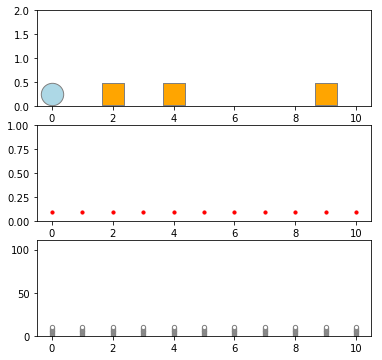

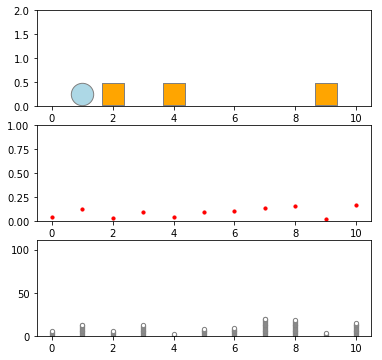

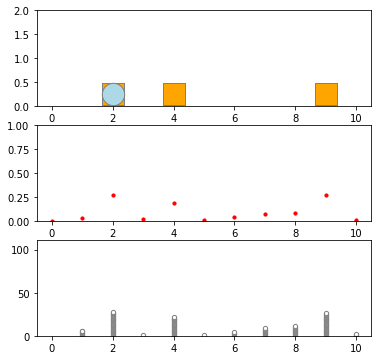

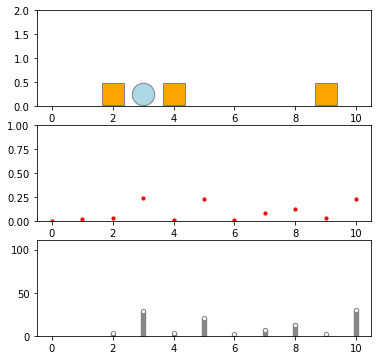

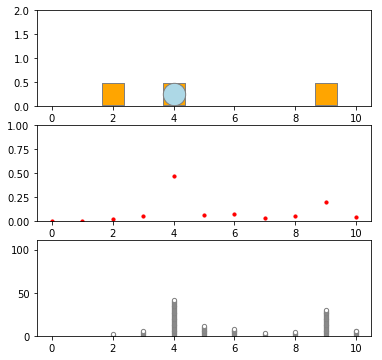

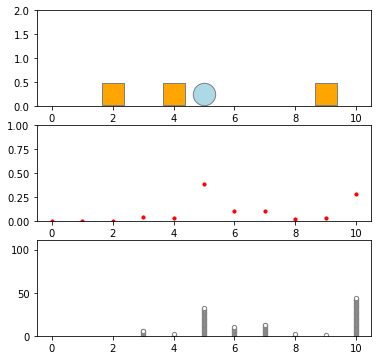

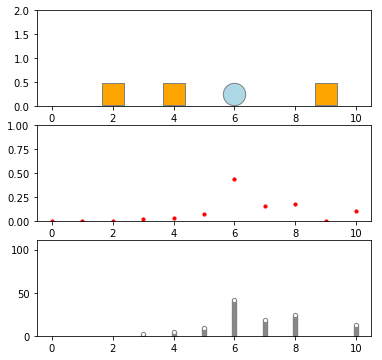

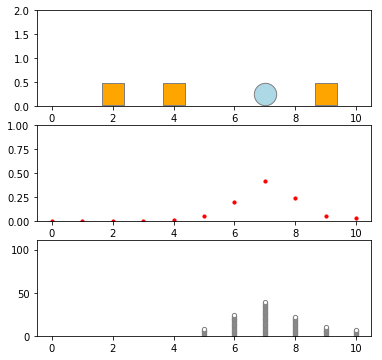

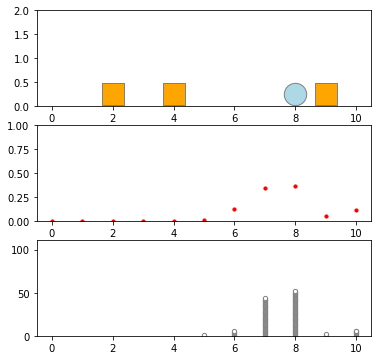

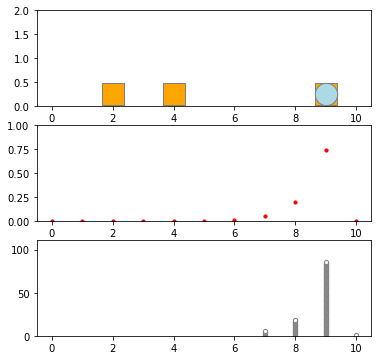

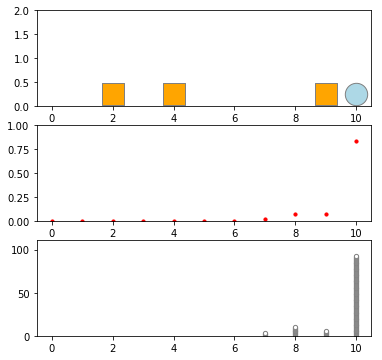

In [8]:
if __name__ == '__main__':
    # クラスの引数はパーティクルの数を調整するゲイン
    # 1～3: 低性能
    # 4～9: 中性能
    # 10～: 高性能
    m1 = MCL(10)
    m1.draw()